In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from genparse import Float, CFGLM
from genparse.cfglm import locally_normalize, EOS, ERROR
from genparse.align.trie import TokenTrieApproximation, NextTokenTrie
from genparse.lm import GreedilyTokenizedLLM
from genparse.util import LarkStuff, display_table
from genparse.inference import TraceSWOR

In [18]:
llm = GreedilyTokenizedLLM("gpt2")

In [19]:
prompt = 'Hello my name is'
pp = llm.p_next(prompt, 10).normalize()
pp

key,value
John,0.16005247146281407
L,0.11619228665146589
J,0.10705686478148731
K,0.1059574421280044
James,0.10455176466452001
Michael,0.08868320379871576
David,0.08729231356700123
Tom,0.07885149745865802
T,0.07649287560150769
Jack,0.07486927988582563


In [5]:
#pp = llm.p_next('Noam Chomsky famously wrote, "', 10)

In [20]:
#NextTokenTrie(pp, '<|endoftext|>').root.graphviz(fmt_node=lambda x: f'{x._mass:.3g}', fmt_edge=lambda i,a,j: repr(a))

In [21]:
#have = {x for x in llm._decode if len(x) == 1}
#want = {y for x in llm._decode for y in x}

In [22]:
#want - have

In [23]:
# create a character-level trie for the next token given the prompt
#NextTokenTrie(pp).show()

In [24]:
pcfg = CFGLM(locally_normalize(LarkStuff(r"""

start: /[ ]*(|Mr\.[ ]|Dr\.[ ])Tim(othy)?[ ](|Fabbri[ ])Vieira(|,[ ]Ph\.D\.)/

""").char_cfg(.99), tol=1e-100))

In [25]:
print(repr(''.join(pcfg.sample())))

' Tim Fabbri Vieira'


In [28]:
token_trie_approx = TokenTrieApproximation(llm, pcfg)
tracer = TraceSWOR()
for _ in range(1):
    with tracer:
        print('----------------------------------')
        ys = token_trie_approx.sample(prompt, max_tokens=50, draw=tracer, verbosity=1)
        print(ys)

----------------------------------
 D|r|.| T|im| F|abb|ri| |V|ie|ira|,| Ph|.|D|.|
 Dr. Tim Fabbri Vieira, Ph.D.


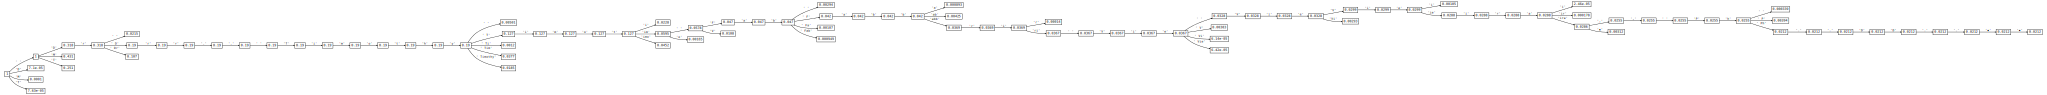

In [29]:
tracer.root.graphviz(fmt_node=lambda x: f'{x._mass:.3g}', fmt_edge=lambda i,a,j: repr(a))

In [30]:
fruit = CFGLM(locally_normalize(LarkStuff(r"""
start: (|" ") sentence

sentence: noun verb noun        
        | noun verb "like" noun 

noun: det* adj* NOUN
verb: VERB
adj: ADJ
det: "a" | "the"

NOUN: "flies" | "banana" | "fruit"
VERB: "like" | "flies"
ADJ: "fruit"

""").char_cfg(.99, ignore='[ ]?'), tol=1e-100))

In [31]:
''.join(fruit.sample())

'  fruit banana flies fruit '

In [32]:
#fruit.cfg.language(20).project(lambda x: ''.join(x))

In [33]:
fruit('fruit flies like a banana ' + EOS)

2.2463994597622037e-05

In [38]:
prompt = 'The following is a favorite sentence among linguists:'
token_trie_approx = TokenTrieApproximation(llm, fruit)
tracer = TraceSWOR()
for _ in range(1):
    with tracer:
        print('----------------------------------')
        ys = token_trie_approx.sample(prompt, max_tokens=50, draw=tracer)
        print(ys)

----------------------------------
1.0
  a the a banana likethe a banana 
